In [ ]:
import numpy as np
import numba
from numba import cuda
import math
import time
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
def noise_generator(input_img, p):
  rnd = np.random.rand(input_img.shape[0], input_img.shape[1])
  input_img[rnd < p] = 0
  input_img[rnd > 1 - p] = 255
  return input_img

In [ ]:
@cuda.jit
def salt_and_pepper_kern(input_img, output_img):
  i, j = cuda.grid(2)
  t = cuda.local.array(shape=9, dtype=numba.int64)

  for idx in range(9):
    t[idx] = input_img[idx//3 - 1 + i][idx % 3 - 1 + j]

  for k in range(8):
    for l in range(8-k):
      if t[l] > t[l+1]:
        t[l], t[l+1] = t[l+1], t[l]
  output_img[i][j] = t[4]

In [ ]:
def salt_and_pepper_gpu(h_input_img):
  block_size = (32, 32)
  grid_size=(math.ceil(h_input_img.shape[0]/block_size[0]), math.ceil(h_input_img.shape[1]/block_size[1]))

  start = cuda.event()
  end = cuda.event()

  start.record()

  d_input_img = cuda.to_device(h_input_img)
  d_output_img = cuda.to_device(np.zeros(h_input_img.shape))
  salt_and_pepper_kern[grid_size, block_size](d_input_img, d_output_img)

  end.record()
  end.synchronize()

  elapsed_time = cuda.event_elapsed_time(start, end)
  return d_output_img.copy_to_host(), elapsed_time / 1000

In [ ]:
def salt_and_pepper_cpu(input_img):
  output_img = np.zeros(input_img.shape)
  for i in range(input_img.shape[0] - 1):
    for j in range(input_img.shape[1] - 1):
      t = np.zeros(9)
      for idx in range(9):
        t[idx] = input_img[idx//3 - 1 + i][idx % 3 - 1 + j]
      for k in range(8):
        for l in range(8-k):
          if t[l] > t[l + 1]:
            t[l], t[l + 1] = t[l + 1], t[l]
      output_img[i][j] = np.median(t)
  return output_img

In [ ]:
img = cv2.imread('/content/peppers.bmp', cv2.IMREAD_GRAYSCALE)

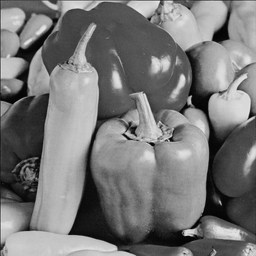

In [ ]:
cv2_imshow(img)

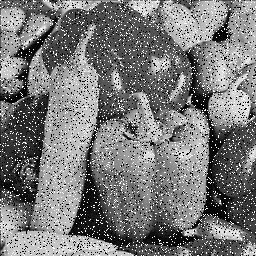

In [ ]:
noise_img = noise_generator(img, 0.08)
cv2_imshow(noise_img)

------------------CPU------------------
CPU time is: 3.661968469619751


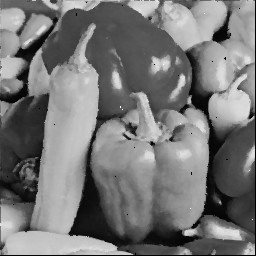

In [ ]:
print("------------------CPU------------------")
start = time.time()
result_cpu = salt_and_pepper_cpu(noise_img)
total_cpu_time = time.time() - start
print(f"CPU time is: {total_cpu_time}")
cv2_imshow(result_cpu)

------------------GPU------------------


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 64 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


GPU time is: 1.5261807861328125


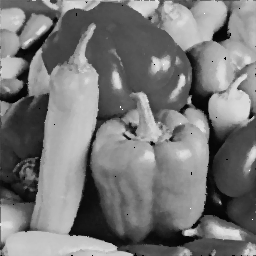

In [ ]:
print("------------------GPU------------------")
result_gpu, time_gpu = salt_and_pepper_gpu(noise_img)
print(f"GPU time is: {time_gpu}")
cv2_imshow(result_gpu)

In [ ]:
print("------------------Acceleration------------------")
print(total_cpu_time / time_gpu)

------------------Acceleration------------------
2.3994329524346902


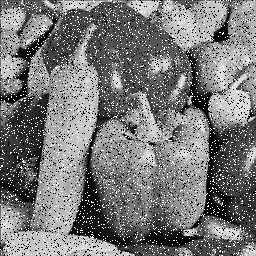

------------------CPU------------------
CPU time is: 8.68019151687622


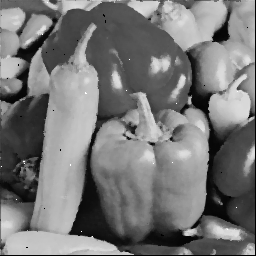

------------------GPU------------------
GPU time is: 0.001990239977836609


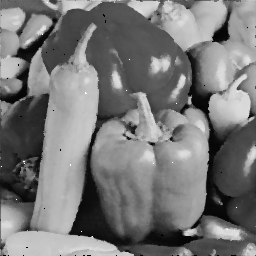

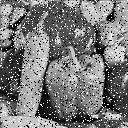

------------------CPU------------------
CPU time is: 0.9646081924438477


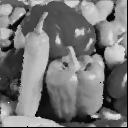

------------------GPU------------------
GPU time is: 0.002517695903778076


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 16 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


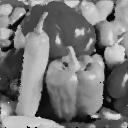

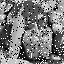

------------------CPU------------------
CPU time is: 0.2517862319946289


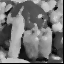

------------------GPU------------------
GPU time is: 0.0019481920003890992


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


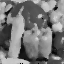

In [ ]:
imgs = ['peppers', 'peppers128', 'peppers64']
for imG in imgs:
  img = cv2.imread('/content/'+imG+'.bmp', cv2.IMREAD_GRAYSCALE)
  noise_img = noise_generator(img, 0.08)
  cv2_imshow(noise_img)
  print("------------------CPU------------------")
  start = time.time()
  result_cpu = salt_and_pepper_cpu(noise_img)
  total_cpu_time = time.time() - start
  print(f"CPU time is: {total_cpu_time}")
  cv2_imshow(result_cpu)
  print("------------------GPU------------------")
  result_gpu, time_gpu = salt_and_pepper_gpu(noise_img)
  print(f"GPU time is: {time_gpu}")
  cv2_imshow(result_gpu)

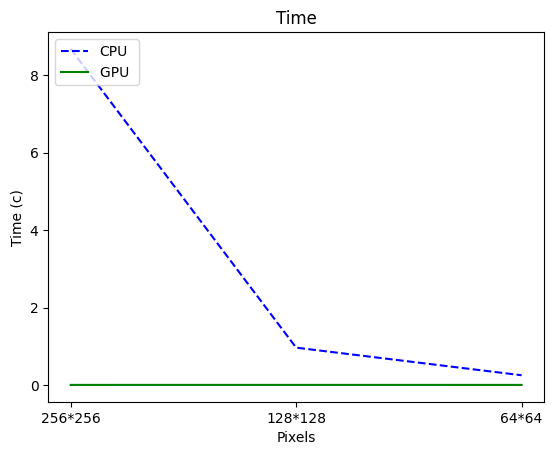

In [ ]:
import matplotlib.pyplot as plt
time_cpu = [8.68019151687622, 0.9646081924438477, 0.2517862319946289]
time_gpu = [0.001990239977836609, 0.002517695903778076, 0.0019481920003890992]
size = ['256*256','128*128','64*64']
plt.title('Time')
plt.xlabel('Pixels')
plt.ylabel('Time (c)')
plt.plot(size,time_cpu,'b--',size,time_gpu,'g')
plt.legend(['CPU','GPU '], loc=2)
plt.show()

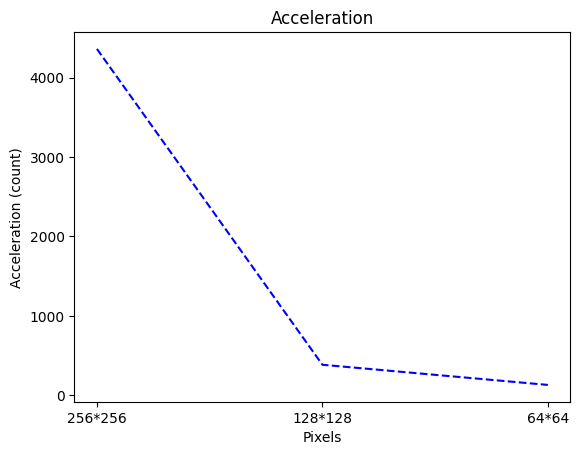

In [ ]:
plt.cla()
plt.title('Acceleration')
plt.xlabel('Pixels')
plt.ylabel('Acceleration (count)')
accel = []
for i in range (len(time_cpu)):
  accel.append(time_cpu[i]/time_gpu[i])

plt.plot(size,accel,'b--')
plt.show()